In [1]:
# pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [3]:
# Read on bitcoin data and provide the percentage change on a daily basis
directory = r"C:\Users\User\OneDrive\MITB\Social\Untitled Folder\Crypto"
os.chdir(directory)
os.getcwd()

bitcoin = pd.read_csv("BitcoinData.csv")
doge = pd.read_csv("DogecoinData.csv")

crypto = bitcoin

crypto["Date"] = crypto.Date.astype("string")
crypto["Price"] = crypto.Price.astype("string")
crypto["Open"] = crypto.Open.astype("string")

crypto["Price"] = crypto["Price"].str.replace(",","")
crypto["Open"] = crypto["Open"].str.replace(",","")
crypto['Price'] =pd.to_numeric(crypto['Price'])
crypto['Open'] = pd.to_numeric(crypto['Open'])

crypto["Change"] = round((crypto["Price"]-crypto["Open"])/crypto["Open"] * 100,3)

# Remove the timing from Date column as it provides no useful information
# get same format as compound score file
crypto["Date"] = crypto["Date"].apply(lambda x: pd.to_datetime(x))

#change bitcoin column name to be same as the compound score files
crypto.rename(columns={'Date': 'Datetime'}, inplace= True)

crypto["Datetime"] = crypto.Datetime.astype("string")
crypto

,Datetime,Price,Open,High,Low,Vol.,Change %,Change
0,2022-04-28,40000.0,39243.0,"40,302.0","38,888.0",472.69M,1.93%,1.929
1,2022-04-27,39243.0,38113.0,"39,447.0","37,869.0",426.83M,2.96%,2.965
2,2022-04-26,38113.0,40443.0,"40,770.0","37,708.0",681.47M,-5.72%,-5.761
3,2022-04-25,40427.0,39464.0,"40,599.0","38,233.0",654.60M,2.44%,2.440
4,2022-04-24,39464.0,39434.0,"39,929.0","39,033.0",283.63M,0.12%,0.076
...,...,...,...,...,...,...,...,...
1574,2018-01-05,16954.8,15180.1,"17,126.9","14,832.4",141.96K,11.69%,11.691
1575,2018-01-04,15180.1,15156.5,"15,408.7","14,244.7",110.97K,0.15%,0.156
1576,2018-01-03,15156.6,14754.1,"15,435.0","14,579.7",106.54K,2.73%,2.728
1577,2018-01-02,14754.1,13444.9,"15,306.1","12,934.2",137.73K,9.74%,9.738


In [4]:
sd = 2.5

mean_change = crypto.describe()["Change"]['mean']
sd_change = crypto.describe()["Change"]['std']

tolerance_upper = mean_change + sd*sd_change
tolerance_lower = mean_change - sd*sd_change
print("We define days with usual price movements as {}% increase and {}% decrease".format(round(tolerance_upper,3),round(tolerance_lower,3)))

We define days with usual price movements as 10.093% increase and -9.797% decrease


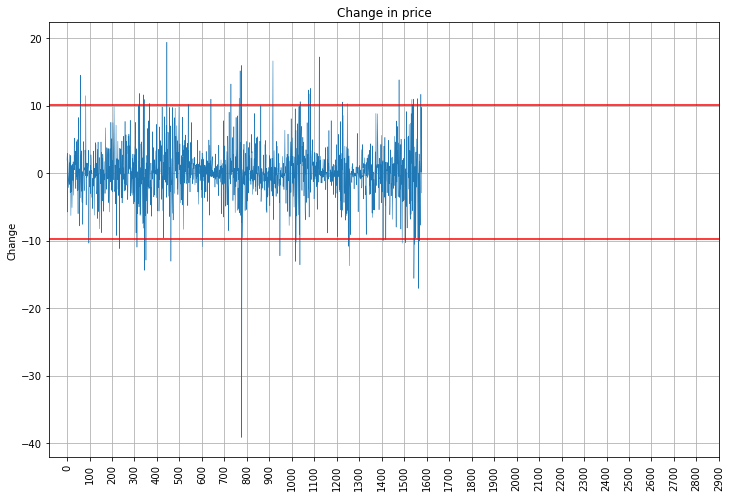

In [5]:
fig, ax1 = plt.subplots(figsize=(12,8))
graph = sns.lineplot(data = crypto, x=crypto.index, y='Change',markers = True,linewidth = 0.5)
ax1.set(title='Change in price')
plt.xticks(np.arange(0,3000,100),rotation = 90)
graph.axhline(tolerance_upper, color = "red")
graph.axhline(tolerance_lower, color = "red")
plt.grid()
plt.show()

In [9]:
unusual_dates_high = {}
unusual_dates_low = {}

for i in crypto["Change"]:
    if i>0 and i>tolerance_upper:
        unusual_dates_high[crypto["Datetime"][crypto.Change == i ].values[0]] = i
    elif i<0 and i<tolerance_lower:
        unusual_dates_low[crypto["Datetime"][crypto.Change == i ].values[0]] = i

print("Dates that have high price increase")
print(unusual_dates_high)
print("\n")
print("Dates that have large drop in price")
print(unusual_dates_low)

Dates that have high price increase
{'2022-03-09': 8.256, '2022-02-28': 14.536, '2022-02-04': 11.478, '2021-11-08': 6.719, '2021-10-15': 7.54, '2021-10-06': 7.486, '2021-10-01': 9.861, '2021-09-22': 7.11, '2021-08-13': 7.668, '2021-07-21': 7.843, '2021-06-13': 10.024, '2021-06-09': 11.822, '2021-05-24': 11.608, '2021-05-20': 10.925, '2021-05-05': 6.625, '2021-04-30': 7.763, '2021-04-26': 10.328, '2021-04-13': 6.143, '2021-03-26': 7.246, '2021-03-13': 6.859, '2021-03-01': 9.821, '2021-02-19': 8.367, '2021-02-11': 7.039, '2021-02-08': 19.412, '2021-01-28': 9.753, '2021-01-22': 7.01, '2021-01-13': 9.75, '2021-01-07': 7.233, '2021-01-06': 8.218, '2021-01-05': 6.172, '2021-01-02': 9.651, '2020-12-17': 6.899, '2020-12-16': 9.866, '2020-11-30': 8.315, '2020-11-05': 10.19, '2020-10-21': 7.513, '2020-07-27': 10.975, '2020-06-01': 7.772, '2020-05-07': 9.037, '2020-04-29': 13.221, '2020-04-16': 6.886, '2020-04-06': 8.261, '2020-03-30': 8.499, '2020-03-23': 11.111, '2020-03-19': 15.166, '2020-03-1

# Sentiment Analysis of Tweets from Influencers

This section we extract tweets and process them

## Scrap Tweets from all excel file in a folder

1) Change your directory to the folder with all the excel files

2) Tweet columns scrapped are
    
    -Datetime
    
    -Tweet ID
    
    -Text
    
    -Username

In [10]:
# assign directory
directory = r"C:\Users\User\OneDrive\MITB\Social\Untitled Folder\Influencers"
os.chdir(directory)

df_consolidated = pd.DataFrame()

# iterate over files in that directory
for filename in os.listdir(r"C:\Users\User\OneDrive\MITB\Social\Untitled Folder\Influencers"):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        df = pd.read_csv(filename)
        df_consolidated = df_consolidated.append(df,ignore_index = True)

df_consolidated

,Unnamed: 0,Datetime,Tweet Id,Text,Username
0,0,2019-01-30 23:48:18+00:00,1090758635024728069,"Jury awards Rand Paul more than $580,000 in da...",business
1,1,2019-01-30 23:37:40+00:00,1090755959029403648,Facebook investors shouldn't get lulled into a...,business
2,2,2019-01-30 23:29:19+00:00,1090753856148070401,"As Tesla bond comes due, a Chinese challenger ...",business
3,3,2019-01-30 23:23:29+00:00,1090752391304134656,Should New York City ride-share drivers get a ...,business
4,4,2019-01-30 23:20:22+00:00,1090751604972769280,"More than 1,000 confidential files somehow fou...",business
...,...,...,...,...,...
369527,311,2022-05-01 09:01:09+00:00,1520689773005877248,"@MacaesBruno Sure but as Poland shows, indepen...",VitalikButerin
369528,312,2022-05-01 08:04:08+00:00,1520675422005960704,@MacaesBruno Can you elaborate? I'm seeing lot...,VitalikButerin
369529,313,2022-05-01 04:32:24+00:00,1520622139069452289,@zengjiajun_eth The only solution is to unders...,VitalikButerin
369530,314,2022-05-01 04:31:06+00:00,1520621813209784321,@zengjiajun_eth Don't think optimizing the con...,VitalikButerin


In [11]:
# Change datetime column to string type so we can clean it

df_consolidated["Datetime"]=df_consolidated["Datetime"].astype("string")
df_consolidated["Datetime"] = df_consolidated["Datetime"].str[:10]
df_consolidated["Datetime"]=df_consolidated["Datetime"].astype("string")
df_consolidated["Datetime"]

0         2019-01-30
1         2019-01-30
2         2019-01-30
3         2019-01-30
4         2019-01-30
             ...    
369527    2022-05-01
369528    2022-05-01
369529    2022-05-01
369530    2022-05-01
369531    2022-05-01
Name: Datetime, Length: 369532, dtype: string

In [12]:
#  this section we explore whether prices with high increase, have positive sentiments

print("Dates that have high price increase")
print(unusual_dates_high)

Dates that have high price increase
{'2022-03-09': 8.256, '2022-02-28': 14.536, '2022-02-04': 11.478, '2021-11-08': 6.719, '2021-10-15': 7.54, '2021-10-06': 7.486, '2021-10-01': 9.861, '2021-09-22': 7.11, '2021-08-13': 7.668, '2021-07-21': 7.843, '2021-06-13': 10.024, '2021-06-09': 11.822, '2021-05-24': 11.608, '2021-05-20': 10.925, '2021-05-05': 6.625, '2021-04-30': 7.763, '2021-04-26': 10.328, '2021-04-13': 6.143, '2021-03-26': 7.246, '2021-03-13': 6.859, '2021-03-01': 9.821, '2021-02-19': 8.367, '2021-02-11': 7.039, '2021-02-08': 19.412, '2021-01-28': 9.753, '2021-01-22': 7.01, '2021-01-13': 9.75, '2021-01-07': 7.233, '2021-01-06': 8.218, '2021-01-05': 6.172, '2021-01-02': 9.651, '2020-12-17': 6.899, '2020-12-16': 9.866, '2020-11-30': 8.315, '2020-11-05': 10.19, '2020-10-21': 7.513, '2020-07-27': 10.975, '2020-06-01': 7.772, '2020-05-07': 9.037, '2020-04-29': 13.221, '2020-04-16': 6.886, '2020-04-06': 8.261, '2020-03-30': 8.499, '2020-03-23': 11.111, '2020-03-19': 15.166, '2020-03-1

In [13]:
res = []
for i in unusual_dates_high.keys():
    res.extend(df_consolidated.index[df_consolidated["Datetime"] == i].tolist())

df_high = df_consolidated.loc[res]
df_high.head()

,Unnamed: 0,Datetime,Tweet Id,Text,Username
325333,24622,2022-03-09,1501709200191279107,Wheat farmers around the world are running at ...,business
325334,24623,2022-03-09,1501707338406838273,Novak Djokovic said that he will not be able t...,business
325335,24624,2022-03-09,1501703757243068417,A flurry of diplomatic calls between Beijing a...,business
325336,24625,2022-03-09,1501697578420875264,The IMF approved $1.4 billion in emergency fin...,business
325337,24626,2022-03-09,1501695352239439878,Citigroup is assessing its operations in Russi...,business


In [14]:
all_tweets = []

#remove multiple \n in tweets, and lowercase all characters
for tweets in df_high["Text"]:
    res = tweets.replace("\n"," ")+"\n"
    all_tweets.append(res.strip("\n").lower())

#remove all @ and hyperlinks
for i in range(len(all_tweets)):
    all_tweets[i] = re.sub(r"@\w+","",all_tweets[i])
    all_tweets[i] = re.sub(r"\bhttps://.+\b","",all_tweets[i])

all_tweets

['wheat farmers around the world are running at full tilt and there’s not much scope to produce more and replenish supplies shut off by russia’s invasion of ukraine ',
 "novak djokovic said that he will not be able to compete at the hard-court tennis tournaments in indian wells, california, or miami because he is unvaccinated and can't travel to the united states, via ap ",
 'a flurry of diplomatic calls between beijing and european capitals shows how xi jinping is trying to keep russia’s invasion of ukraine from dragging china into another struggle for global supremacy ',
 'the imf approved $1.4 billion in emergency financing for ukraine ',
 'citigroup is assessing its operations in russia ',
 'russia appears to be letting some ships carrying grains exit the azov sea, the first signs of activity since shipping in the waterway linked to the black sea was suspended ',
 'french hotel operator accor said it’s keeping its 57 russian locations open while suspending future developments in th

In [15]:
# filter_crypto = ["eth","bitcoin","coindesk"," ethereum","crypto","cryptography","cryptocurrency","nfts","nft's","coin","doge","dogecoin","stablecoin","fiat","token","mine","mining","miners","altcoin","blockchain","hodl","wallet","wallets"]
# crypto_tweets = []
# # as long as one of the filter words are in the tweets, we capture them
# for tweets in all_tweets:
#     for i in filter_crypto:
#         if i in tweets:
#             crypto_tweets.append(tweets)
#             break
            
# print("From {} number of tweets, this influencer has tweeted {} related to crypto".format(len(all_tweets),len(crypto_tweets)))
# crypto_tweets

In [28]:
# Next, we tokenize the processed tweets, to conduct our Topic Modelling. 

def is_valid_token(token):
    # keep hashtag, but not user mentions, i've retained the code for keeping user mentions
    # if ((token.startswith('#') or token.startswith('@')) and len(token) > 2):
    if (token.startswith('#') and len(token) > 2):
        return True
    # if a token contains at least two consective English letters, we assume it's a word
    if re.match(r'.*[a-z]{2,}.*', token):
        return True
    return False

tt = TweetTokenizer()
crypto_tokens = [tt.tokenize(doc) for doc in all_tweets]
crypto_tokens = [[token for token in doc if is_valid_token(token)] for doc in crypto_tokens]
crypto_tokens

[['there',
  'been',
  'call',
  'on',
  'the',
  'street',
  'would',
  'say',
  'for',
  'the',
  'last',
  'two',
  'months',
  'for',
  'something',
  'like',
  'this',
  'jewelry',
  'insiders',
  'have',
  'been',
  'on',
  'the',
  'hunt',
  'for',
  'massive',
  'green',
  'diamond',
  'for',
  'the',
  'last',
  'two',
  'months',
  'and',
  'they',
  "didn't",
  'know',
  'who',
  'it',
  'was',
  'for',
  'until',
  'now'],
 ['jewelry',
  'insiders',
  'have',
  'been',
  'on',
  'the',
  'hunt',
  'for',
  'massive',
  'green',
  'diamond',
  'for',
  'the',
  'last',
  'two',
  'months',
  'and',
  'they',
  "didn't",
  'know',
  'who',
  'it',
  'was',
  'for',
  'until',
  'now'],
 ['based',
  'biotech',
  'firm',
  'engitix',
  'and',
  'japanese',
  'drugmaker',
  'takeda',
  'have',
  'agreed',
  'to',
  'extend',
  'their',
  'existing',
  'partnership',
  'in',
  'deal',
  'could',
  'be',
  'valued',
  'at',
  'as',
  'much',
  'as',
  'million'],
 ['new',
  'rules

In [29]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# remove stop words
stop_set = set(stopwords.words('english'))
crypto_tokens = [[token for token in doc if token not in stop_set] for doc in crypto_tokens]

# # stemming
stemmer = PorterStemmer()
# only perform stemming on tokens not starting with # or @
crypto_tokens = [[token if token.startswith('#') or token.startswith('@') else stemmer.stem(token) for token in doc] for doc in crypto_tokens]


# remove documents with fewer than three words
crypto_tokens = [doc for doc in crypto_tokens if len(doc) >= 3]

# Apply topic modeling

We will apply Latent Dirichlet Allocation (LDA) to discover topics in the documents, and use gensim

In [30]:
from gensim import corpora, models

# construct vocabulary
vocab = corpora.Dictionary(crypto_tokens)

# construct bag of words, i.e., word vecors
bow = [vocab.doc2bow(doc) for doc in crypto_tokens]

In [31]:
# build the model
n_topic = 10
lda = models.LdaModel(bow, id2word = vocab, num_topics = n_topic)

# print out each topic, where each topic is represented by top n words
print("Topics")
for i in range(n_topic):
    print(i, ':', lda.print_topic(i, topn = 5))

Topics
0 : 0.021*"china" + 0.018*"trump" + 0.009*"hous" + 0.008*"trade" + 0.008*"make"
1 : 0.066*"de" + 0.024*"que" + 0.023*"el" + 0.016*"lo" + 0.015*"en"
2 : 0.011*"year" + 0.011*"first" + 0.010*"new" + 0.010*"may" + 0.010*"south"
3 : 0.017*"billion" + 0.011*"new" + 0.010*"compani" + 0.010*"coronaviru" + 0.009*"plan"
4 : 0.019*"stock" + 0.013*"china" + 0.012*"market" + 0.009*"trade" + 0.009*"new"
5 : 0.012*"say" + 0.011*"presid" + 0.009*"minist" + 0.008*"govern" + 0.008*"trump"
6 : 0.028*"la" + 0.021*"bank" + 0.017*"say" + 0.012*"cut" + 0.011*"fund"
7 : 0.022*"trump" + 0.014*"say" + 0.009*"democrat" + 0.008*"get" + 0.008*"elect"
8 : 0.021*"here'" + 0.016*"econom" + 0.016*"news" + 0.016*"top" + 0.014*"market"
9 : 0.023*"coronaviru" + 0.015*"new" + 0.013*"brexit" + 0.009*"hong" + 0.008*"outbreak"


In [32]:
# pip install wordcloud

In [33]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt


In [34]:
res1 = []

for i in range(n_topic):
    r1 = re.findall(r"[a-z]+",lda.print_topic(i,topn = 5))
    res1.extend(r1)
res1 = " ".join(res1)
res1

'china trump hous trade make de que el lo en year first new may south billion new compani coronaviru plan stock china market trade new say presid minist govern trump la bank say cut fund trump say democrat get elect here econom news top market coronaviru new brexit hong outbreak'

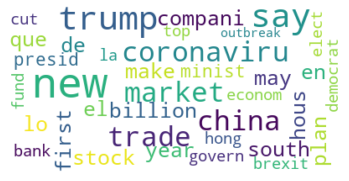

In [40]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(res1)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [41]:
# Once you are satisfied with word, save the image in the img folder:
wordcloud.to_file("C:/Users/User/OneDrive/MITB/Social/Untitled Folder/highclouddoge.png")

# We will now explore topics for days with large decrease in price

In [46]:
res = []
for i in unusual_dates_low.keys():
    res.extend(df_consolidated.index[df_consolidated["Datetime"] == i].tolist())

df_low = df_consolidated.loc[res]

all_tweets = []

#remove multiple \n in tweets, and lowercase all characters
for tweets in df_low["Text"]:
    res = tweets.replace("\n"," ")+"\n"
    all_tweets.append(res.strip("\n").lower())

#remove all @ and hyperlinks
for i in range(len(all_tweets)):
    all_tweets[i] = re.sub(r"@\w+","",all_tweets[i])
    all_tweets[i] = re.sub(r"\bhttps://.+\b","",all_tweets[i])
    
# filter_crypto = ["eth","bitcoin","coindesk"," ethereum","crypto","cryptocurrency","nfts","nft's","coin","doge","dogecoin","stablecoin","fiat","token","mine","mining","miners","altcoin","blockchain","hodl","wallet","wallets"]
# crypto_tweets = []
# # as long as one of the filter words are in the tweets, we capture them
# for tweets in all_tweets:
#     for i in filter_crypto:
#         if i in tweets:
#             crypto_tweets.append(tweets)
#             break
            
tt = TweetTokenizer()
crypto_tokens = [tt.tokenize(doc) for doc in all_tweets]
crypto_tokens = [[token for token in doc if is_valid_token(token)] for doc in crypto_tokens]
crypto_tokens

# remove stop words
stop_set = set(stopwords.words('english'))
crypto_tokens = [[token for token in doc if token not in stop_set] for doc in crypto_tokens]

# remove documents with fewer than three words
crypto_tokens = [doc for doc in crypto_tokens if len(doc) >= 3]


In [56]:
# construct vocabulary
vocab = corpora.Dictionary(crypto_tokens)

# construct bag of words, i.e., word vecors
bow = [vocab.doc2bow(doc) for doc in crypto_tokens]

# build the model
n_topic = 10
lda = models.LdaModel(bow, id2word = vocab, num_topics = n_topic)

# print out each topic, where each topic is represented by top n words
print("Topics")
for i in range(n_topic):
    print(i, ':', lda.print_topic(i, topn = 5))

Topics
0 : 0.065*"de" + 0.024*"que" + 0.024*"la" + 0.023*"el" + 0.015*"en"
1 : 0.017*"brexit" + 0.011*"here's" + 0.010*"news" + 0.010*"president" + 0.009*"top"
2 : 0.017*"new" + 0.011*"world" + 0.011*"trump" + 0.011*"change" + 0.008*"climate"
3 : 0.025*"trade" + 0.008*"could" + 0.008*"get" + 0.007*"trump" + 0.007*"says"
4 : 0.015*"new" + 0.011*"coronavirus" + 0.010*"state" + 0.007*"court" + 0.006*"company"
5 : 0.028*"coronavirus" + 0.016*"new" + 0.008*"economy" + 0.007*"china" + 0.007*"government"
6 : 0.020*"trump" + 0.012*"tariffs" + 0.011*"says" + 0.010*"johnson" + 0.009*"boris"
7 : 0.021*"trump" + 0.014*"hong" + 0.013*"kong" + 0.012*"coronavirus" + 0.009*"donald"
8 : 0.016*"bank" + 0.012*"central" + 0.009*"day" + 0.009*"market" + 0.008*"need"
9 : 0.018*"china" + 0.011*"year" + 0.011*"oil" + 0.009*"billion" + 0.008*"since"


In [57]:
res2 = []

for i in range(n_topic):
    r1 = re.findall(r"[a-z]+",lda.print_topic(i,topn = 5))
    res2.extend(r1)
res2 = " ".join(res2)
res2

'de que la el en brexit here s news president top new world trump change climate trade could get trump says new coronavirus state court company coronavirus new economy china government trump tariffs says johnson boris trump hong kong coronavirus donald bank central day market need china year oil billion since'

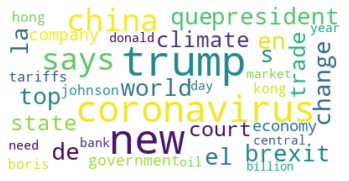

In [58]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(res2)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [59]:
# Once you are satisfied with the wordcloud, save the image in the img folder:
wordcloud.to_file("C:/Users/User/OneDrive/MITB/Social/Untitled Folder/lowclouddoge.png")